In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import os
import torch
import plotly.graph_objects as go
import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm_notebook, trange

In [3]:
from mpl_finance import candlestick_ohlc

In [4]:
data = pd.read_csv('MCOBTC-1h-data.csv')
all_columns = data.columns

In [5]:
data.head()

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2018-01-01 00:00:00.000,0.001099,0.001102,0.001092,0.001102,27753.59,1514768399999,30.416110,642,10827.46,11.870699,0
1,2018-01-01 01:00:00.000,0.001101,0.001125,0.001098,0.001124,28588.21,1514771999999,31.797533,1187,19507.04,21.711459,0
2,2018-01-01 02:00:00.000,0.001125,0.001140,0.001124,0.001136,35061.85,1514775599999,39.699921,1269,18680.29,21.154370,0
3,2018-01-01 03:00:00.000,0.001136,0.001144,0.001128,0.001128,48461.73,1514779199999,55.074600,1592,22051.48,25.068029,0
4,2018-01-01 04:00:00.000,0.001128,0.001134,0.001122,0.001127,41493.96,1514782799999,46.828720,1463,16507.10,18.631104,0


In [6]:
# Some data_processed preprocessing
data_processed = data.copy()

timestamp = pd.to_datetime(data_processed['timestamp'])
data_processed['year'] = timestamp.dt.year.values.astype(int)
data_processed['month'] = timestamp.dt.month.values.astype(int)
data_processed['day'] = timestamp.dt.day.values.astype(int)
data_processed['hour'] = timestamp.dt.hour.values.astype(int)
data_processed = data_processed.drop('timestamp', axis=1)

In [12]:
data_train = data[:-len(data)//5]
data_test = data[-len(data)//5:]

In [13]:
print('Train size: ', len(data_train), 'hours')
print('Test size: ', len(data_test), 'hours')

Train size:  15641 hours
Test size:  3911 hours


In [14]:
data_train.to_csv('MCOBTC-1h-data_train.csv')
data_test.to_csv('MCOBTC-1h-data_test.csv')

In [15]:
fig = go.Figure(data=go.Ohlc(x=data['timestamp'],
                    open=data['open'],
                    high=data['high'],
                    low=data['low'],
                    close=data['close']))

# Add title and annotations
fig.update_layout(title_text='MCO/BTC historical data',
                  title={
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  xaxis_rangeslider_visible=True, xaxis_title="Time", yaxis_title="MCO/BTC")


fig.show()

In [16]:
drop_columns = ['timestamp', 'close_time', 'ignore']
target_columns = ['open', 'high', 'low', 'close', 'volume']

class Trading_data(Dataset):
    
    def __init__(self, csv_file, hist_len=100, target_len=10, drop_columns=drop_columns,
                 target_columns=target_columns, transform=None):
        #define working columns
        self.target_columns = target_columns
        self.drop_columns = drop_columns
        #load whole historical data
        self.whole_set = pd.read_csv(csv_file).drop('close_time', axis=1)
        timestamp = pd.to_datetime(self.whole_set['timestamp'])
        self.whole_set['year'] = timestamp.dt.year.values.astype(int)
        self.whole_set['month'] = timestamp.dt.month.values.astype(int)
        self.whole_set['day'] = timestamp.dt.day.values.astype(int)
        self.whole_set['hour'] = timestamp.dt.hour.values.astype(int)
        self.whole_set['minute'] = timestamp.dt.minute.values.astype(int)
        self.whole_set = self.whole_set.drop('timestamp', axis=1)
        self.transforms = transforms
        self.hist_len = hist_len
        self.target_len = target_len
        self.transform = transform
        
    def __len__(self):
        return len(self.whole_set) - self.hist_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
            
        history = self.whole_set[idx:idx+self.hist_len].values
        target = self.whole_set[idx+self.hist_len:idx+self.hist_len+self.target_len][self.target_columns].values
        
        sample = {'history': history, 'target': target}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class Normalize(object):
    """Rescale the history in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of history edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, scaler):
        self.scaler = scaler

    def __call__(self, sample):
        history, target = sample['history'], sample['target']

        num_features, t = history.shape
        if self.scaler == 'minmax':
            minmax = MinMaxScaler()
            minmax_target = MinMaxScaler()
            minmax.fit(history)
            minmax_target.fit(history[:, :5])
            
            history = minmax.transform(history)
            target = minmax_target.transform(target)
            
        elif self.scaler == 'std':
            sts = StandardScaler()
            sts_target = StandardScaler()
            sts.fit(history)
            sts_target.fit(history[:, :5])
            
            history = sts.transform(history)
            target = sts_target.transform(target)

        return {'history': history, 'target': target}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        history, target = sample['history'], sample['target']

        return {'history': torch.from_numpy(history),
                'target': torch.from_numpy(target)}

In [17]:
mco_dataset_train = Trading_data('MCOBTC-1h-data_train.csv', 
                                 transform=transforms.Compose([Normalize('minmax'), 
                                 ToTensor()]))

mco_dataset_test = Trading_data('MCOBTC-1h-data_test.csv', 
                                 transform=transforms.Compose([Normalize('minmax'), 
                                 ToTensor()]))

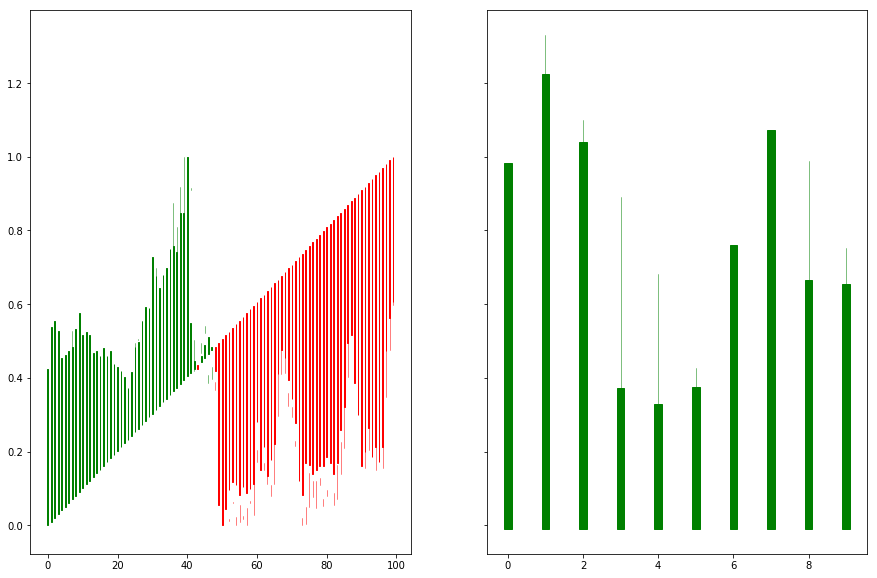

In [22]:
def show_sample(sample):
    history = sample['history']
    target = sample['target']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
    
    history = history.numpy()
    target = target.numpy()
    
    candlestick_ohlc(ax1, zip(range(len(history)), *history[:, :4].T), colorup='g')
    candlestick_ohlc(ax2, zip(range(len(target)), *target[:, :4].T), colorup='g')

show_sample(mco_dataset_train[1])

In [20]:
sample = mco_dataset_train[11]

history = sample['history']
target = sample['target']

In [21]:
history

tensor([[0.0000, 0.4570, 0.3648,  ..., 0.0000, 0.4783, 0.0000],
        [0.0101, 0.3867, 0.3160,  ..., 0.0000, 0.5217, 0.0000],
        [0.0202, 0.4062, 0.3094,  ..., 0.0000, 0.5652, 0.0000],
        ...,
        [0.9798, 0.5781, 0.7231,  ..., 1.0000, 0.5652, 0.0000],
        [0.9899, 0.8516, 0.7329,  ..., 1.0000, 0.6087, 0.0000],
        [1.0000, 0.4961, 0.5505,  ..., 1.0000, 0.6522, 0.0000]],
       dtype=torch.float64)

In [11]:
dataloader_train = DataLoader(mco_dataset, batch_size=1, num_workers=4)

In [ ]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        return self.decoder(self.encoder(x))# >>> your solution here <<<

In [ ]:
data = 

In [ ]:
device = 'cuda'# >>> your solution here <<<

net = MyFirstAE(encoder, decoder)  
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.35)# >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.4)# >>> your solution here <<<


train_loader = torch_data.DataLoader(train_dset, batch_size=50, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=200, shuffle=False) 

In [ ]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X = X.to(device)
            output = net(X)
            loss = criterion(output, X)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # >>> your solution here <<<
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, _ in val_loader:
            # Compute the validation loss
            X = X.to(device)
            val_output = net(X)
            val_loss = criterion(val_output, X)
            # >>> your solution here <<<
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))

In [ ]:
encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
        )

decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )

In [12]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['history'].size(),
          sample_batched['target'].size())
    break

0 torch.Size([1, 100, 15]) torch.Size([1, 10, 5])


In [13]:
class MV_LSTM(torch.nn.Module):
    
    global device
    
    def __init__(self,n_features,seq_length, out_features, seq_out):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.out_features = out_features
        self.seq_out = seq_out
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 10 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.drop1 = torch.nn.Dropout2d(p=0.1)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 50)


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden, device=device)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden, device=device)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x).reshape((batch_size, self.seq_out, self.out_features))

In [14]:
n_features = 15 # this is number of parallel inputs
n_timesteps = 100 # this is number of timesteps

# create NN
mv_net = MV_LSTM(n_features,n_timesteps, 5, 10)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

In [16]:
from tqdm import tqdm_notebook, trange

In [ ]:

device = 'cuda'
mv_net.to(device)
mv_net.train()
mv_net.to(device)
epochs = 20



for i in trange(epochs):
    t = tqdm_notebook(total=len(mco_dataset))
        
    for num_it, sample_batched in enumerate(dataloader):
        try:
            history = sample_batched['history'].to(device)
            target = sample_batched['target'].to(device)

            mv_net.init_hidden(history.to(device).size(0))
            output = mv_net(history.float()) 
            loss = criterion(output, target.float())
            
            t.update(num_it)

            if num_it%250 == 0:
                print(num_it)


            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()
            
        except:
            #t.update(num_it)
            break
    
    t.close()
    print(i)
    if i%10 == 0:
        print('Epoch : ' , i , 'loss : ' , loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

0
250
500
750
1000
1250
1500
1750
2000
2250
2500


In [25]:
loss

tensor(0.0925, device='cuda:0', grad_fn=<MseLossBackward>)

In [26]:
sample = mco_dataset[100]
history = sample['history']
target = sample['target']

In [27]:
mv_net(history.float())

ValueError: not enough values to unpack (expected 3, got 2)

In [129]:
target

tensor([[ 1.2993,  1.2169,  1.3861,  1.2056, -0.7401],
        [ 1.2488,  1.0885,  1.2831,  1.0852,  1.0885],
        [ 1.1073,  0.9503,  1.3758,  1.1454, -0.8216],
        [ 1.1881,  0.9700,  1.3037,  1.1454, -0.5105],
        [ 1.1578,  1.0194,  1.3964,  1.2858, -0.2712],
        [ 1.2892,  1.0095,  1.2110,  1.0551,  0.1060],
        [ 1.0972,  0.8713,  1.1491,  0.9548, -0.1055],
        [ 0.9658,  0.9306,  0.9534,  0.7541,  0.5208],
        [ 0.7637,  0.5652,  0.7473,  0.5233,  0.1845],
        [ 0.5313,  0.5060,  0.7885,  0.7742, -1.0752]], dtype=torch.float64)

In [130]:
history

tensor([[ 0.8041,  0.6541,  0.7679,  ..., -1.4412, -0.9189,  0.0000],
        [ 0.5111,  1.1576,  0.6751,  ..., -1.4412, -0.7730,  0.0000],
        [ 1.3701,  2.2536,  1.5716,  ..., -1.4412, -0.6272,  0.0000],
        ...,
        [ 1.1578,  0.9898,  1.3964,  ...,  1.7614, -0.7730,  0.0000],
        [ 1.1376,  1.2860,  1.3346,  ...,  1.7614, -0.6272,  0.0000],
        [ 1.5722,  1.4637,  1.3243,  ...,  1.7614, -0.4813,  0.0000]],
       dtype=torch.float64)

In [62]:
sample = history

In [63]:
sample[0]

array([1.17000000e-03, 1.18300000e-03, 1.14000000e-03, 1.14300000e-03,
       4.69741200e+04, 5.44548958e+01, 6.81000000e+02, 1.80244700e+04,
       2.08946751e+01, 0.00000000e+00, 2.01800000e+03, 1.00000000e+00,
       5.00000000e+00, 5.00000000e+00, 0.00000000e+00])

In [28]:
composed = transforms.Compose([Normalize])

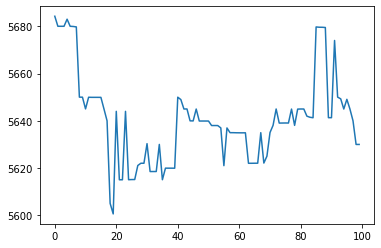

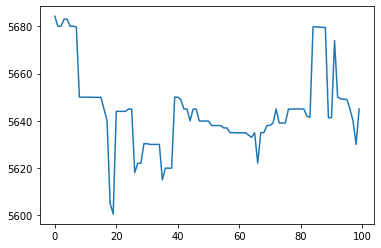

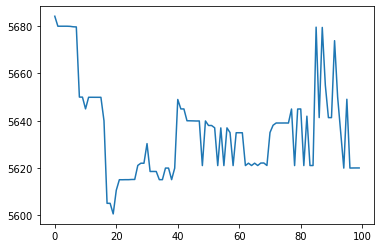

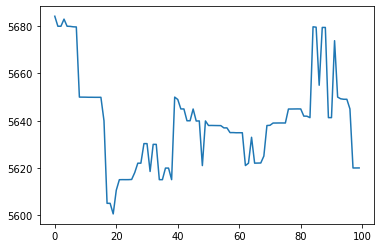

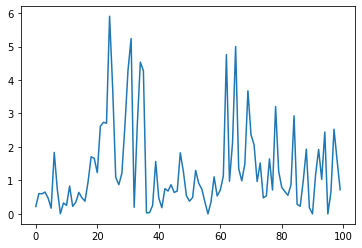

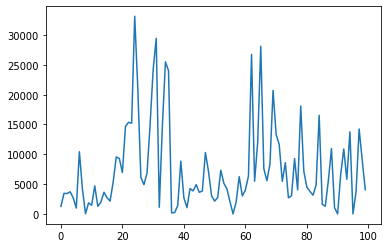

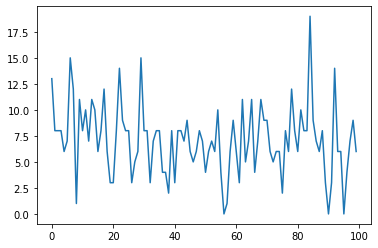

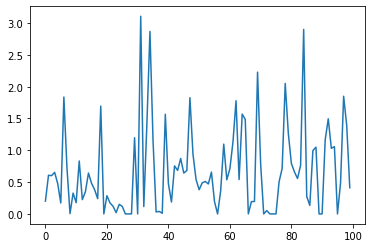

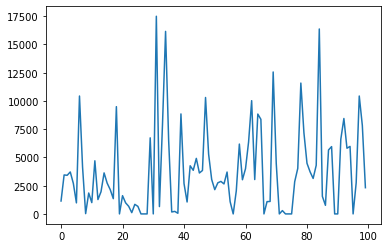

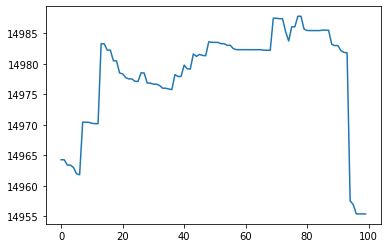

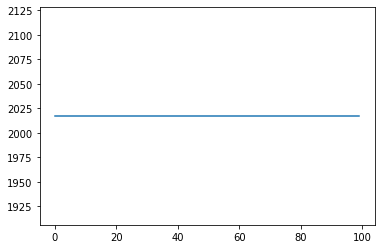

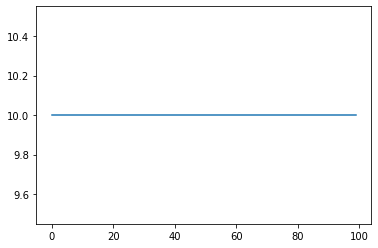

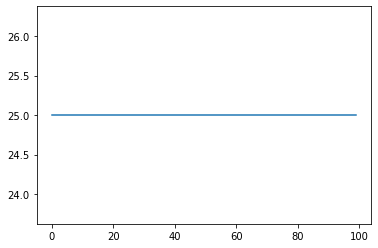

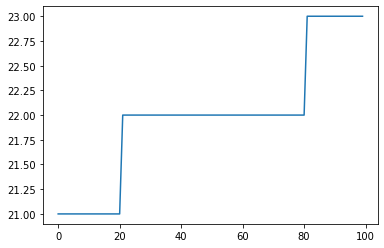

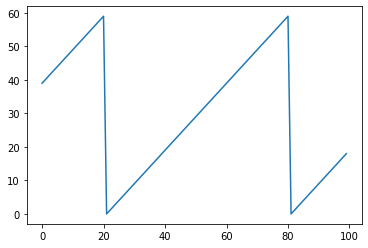

In [66]:
for i in range(history.shape[1]):
    plt.figure()
    plt.title()
    plt.plot(range(100), history[:, i])

In [ ]:
list(zip(np.arange(len(sample['history'])), *sample['history'][:, :4]))

In [6]:
j = 0

for i in range(len(bitcoin_dataset)):
    sample = bitcoin_dataset[i]
#     plt.figure()
    print(sample['target'])
    j+=1
    if j>5:
        break

[[4.29137e+03 4.29137e+03 4.29137e+03 4.29137e+03 0.00000e+00]
 [4.29137e+03 4.29137e+03 4.29137e+03 4.29137e+03 0.00000e+00]
 [4.29137e+03 4.29137e+03 4.29137e+03 4.29137e+03 0.00000e+00]
 [4.29137e+03 4.29137e+03 4.29137e+03 4.29137e+03 0.00000e+00]
 [4.29137e+03 4.29137e+03 4.29137e+03 4.29137e+03 0.00000e+00]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 7.88400e-03]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 0.00000e+00]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 0.00000e+00]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 0.00000e+00]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 0.00000e+00]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 0.00000e+00]
 [4.29704e+03 4.29704e+03 4.29704e+03 4.29704e+03 0.00000e+00]
 [4.31532e+03 4.31532e+03 4.31532e+03 4.31532e+03 9.43000e-04]
 [4.31532e+03 4.31532e+03 4.31532e+03 4.31532e+03 0.00000e+00]
 [4.31532e+03 4.31532e+03 4.31532e+03 4.31532e+03 0.00000e+00]]
[[4.29137e+03 4.29137e+03 4.29137e+03 4.29137e+03 0.00